# 辺のペアを削除した時の挙動確認

In [124]:
import plotly.graph_objects as go
import networkx as nx
import pandas as pd

from matplotlib import pyplot as plt

In [125]:
GRAPH_INPUT = '../s7_mini_seed7427.txt'

with open(GRAPH_INPUT, 'r') as f:
    graph_def_str = f.readline().replace('\n', '')
    
graph_def = list(map(int, graph_def_str.split()))    

In [126]:
N, M, D, K = graph_def[:4]
graph_def = graph_def[4:]

edge_info_list = {}
edge_list = []

for i in range(M):
    u = graph_def.pop(0)
    v = graph_def.pop(0)
    w = graph_def.pop(0)
    
    if u not in edge_info_list.keys():
        edge_info_list[u] = []
        
    if v not in edge_info_list.keys():
        edge_info_list[v] = []

    edge_info_list[u].append((i,v,w))
    edge_info_list[v].append((i,u,w))
    
    edge_list.append((u, v, w))

pos_list = {}

for i in range(N):
    u = i + 1
    x = graph_def.pop(0)
    y = graph_def.pop(0)
    
    pos_list[u] = (x, y)

In [127]:
G = nx.Graph()
G.add_weighted_edges_from(edge_list)

In [128]:
edge_pair_cost_diff_df = pd.read_csv('../05_EdgePairStat/mini_seed7427.csv')

edge_pair_cost_diff_df.columns = ['e1', 'e2', 'cost_diff']
edge_pair_cost_diff_df = edge_pair_cost_diff_df.query('cost_diff != 0')

In [129]:
edge_pair_cost_diff_df['cost_diff'].describe()

count    2.852370e+05
mean     2.082922e+03
std      4.393357e+04
min     -1.799297e+06
25%      1.000000e+00
50%      1.000000e+00
75%      2.700000e+01
max      3.191379e+06
Name: cost_diff, dtype: float64

## コスト増/減のケースで確認

In [153]:
cost_down = True

In [181]:
edge_pair_cost_diff_df.sort_values('cost_diff', ascending=cost_down, inplace=True)
edge_pair_cost_diff_df[:10]

,e1,e2,cost_diff
376754,554,867,-1799297
376595,554,708,-1565737
426727,708,867,-1524688
62639,67,867,-1519038
419950,682,863,-1500530
62326,67,554,-1467931
394931,602,924,-1397590
175787,205,924,-1329842
175465,205,602,-1324838
175222,205,359,-1300325


In [192]:
e = 96
edge_pair_cost_diff_df.query('e1=={} or e2=={}'.format(e, e))[:10]

,e1,e2,cost_diff
87709,96,591,-509048
87736,96,618,-474408
87563,96,445,-468479
87636,96,518,-214810
87391,96,273,-158542
87695,96,577,-152728
87368,96,250,-152420
87802,96,684,-137287
87890,96,772,-131257
87648,96,530,-128420


In [155]:
K = 0

e1 = edge_pair_cost_diff_df['e1'].to_list()[K]
e2 = edge_pair_cost_diff_df['e2'].to_list()[K]

e1, e2

(554, 867)

In [156]:
u1, v1, w1 = edge_list[e1]
print('u={}, v={}, w={}'.format(u1, v1, w1))

ux, uy = pos_list[u1]
vx, vy = pos_list[v1]
print('u=({}, {}), v=({}, {})'.format(ux, uy, vx, vy))

u=200, v=244, w=26627
u=(421, 498), v=(436, 476)


In [157]:
u2, v2, w2 = edge_list[e2]
print('u={}, v={}, w={}'.format(u2, v2, w2))

ux, uy = pos_list[u2]
vx, vy = pos_list[v2]
print('u=({}, {}), v=({}, {})'.format(ux, uy, vx, vy))

u=200, v=220, w=53075
u=(421, 498), v=(385, 537)


In [158]:
del_edge = set()

del_edge.add((u1, v1))
del_edge.add((v1, u1))

del_edge.add((u2, v2))
del_edge.add((v2, u2))

In [159]:
orig_all_path_cost = dict(nx.all_pairs_dijkstra_path_length(G))

del_G1 = G.copy()
del_G1.remove_edge(u1, v1)

del_G1_all_path_cost = dict(nx.all_pairs_dijkstra_path_length(del_G1))

del_G2 = G.copy()
del_G2.remove_edge(u2, v2)

del_G2_all_path_cost = dict(nx.all_pairs_dijkstra_path_length(del_G2))

del_G12 = G.copy()
del_G12.remove_edge(u1, v1)
del_G12.remove_edge(u2, v2)

del_G12_all_path_cost = dict(nx.all_pairs_dijkstra_path_length(del_G12))

In [160]:
node_up_cost_list = []

for node in range(1, N+1):
    up_cost_1 = sum(del_G1_all_path_cost[node].values())
    up_cost_1 -= sum(orig_all_path_cost[node].values())
    up_cost_1 *= 1000
    up_cost_1 /= N * (N-1)
    
    up_cost_2 = sum(del_G2_all_path_cost[node].values())
    up_cost_2 -= sum(orig_all_path_cost[node].values())
    up_cost_2 *= 1000
    up_cost_2 /= N * (N-1)

    up_cost_12 = sum(del_G12_all_path_cost[node].values())
    up_cost_12 -= sum(orig_all_path_cost[node].values())
    up_cost_12 *= 1000
    up_cost_12 /= N * (N-1)
    
    up_cost_12 -= up_cost_1 + up_cost_2
    
    node_up_cost_list.append(up_cost_12)

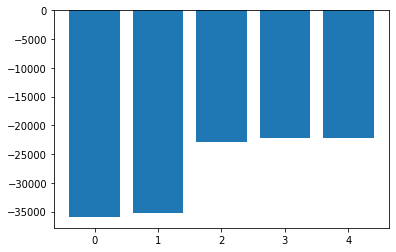

In [161]:
node_cost_up_df = pd.DataFrame()

node_cost_up_df['N'] = [i for i in range(1, N+1)]
node_cost_up_df['cost_up'] = node_up_cost_list

node_cost_up_df.sort_values('cost_up', ascending=cost_down, inplace=True)

K= 5
plt.bar(range(K), node_cost_up_df[:K]['cost_up']);

In [162]:
node_cost_up_df[:K]

,N,cost_up
219,220,-36031.959920
243,244,-35195.583166
47,48,-22891.402806
186,187,-22132.757515
9,10,-22132.757515


In [163]:
target_N = node_cost_up_df['N'].to_list()[0]
target_N

220

In [164]:
orig_shortest_path = nx.shortest_path(G, source=target_N, weight='weight')

del_G1_shortest_path = nx.shortest_path(del_G1, source=target_N, weight='weight')
del_G2_shortest_path = nx.shortest_path(del_G2, source=target_N, weight='weight')
del_G12_shortest_path = nx.shortest_path(del_G12, source=target_N, weight='weight')

In [171]:
orig_node_pair = set()

del_G1_node_pair = set()
del_G2_node_pair = set()
del_G12_node_pair = set()

for node in range(1, N+1):
    for i in range(1, len(orig_shortest_path[node])):
        n1 = orig_shortest_path[node][i-1]
        n2 = orig_shortest_path[node][i]
        
        orig_node_pair.add((n1, n2))
        orig_node_pair.add((n2, n1))

    for i in range(1, len(del_G1_shortest_path[node])):
        n1 = del_G1_shortest_path[node][i-1]
        n2 = del_G1_shortest_path[node][i]
        
        del_G1_node_pair.add((n1, n2))
        del_G1_node_pair.add((n2, n1))
        
    for i in range(1, len(del_G2_shortest_path[node])):
        n1 = del_G2_shortest_path[node][i-1]
        n2 = del_G2_shortest_path[node][i]
        
        del_G2_node_pair.add((n1, n2))
        del_G2_node_pair.add((n2, n1))
        
    for i in range(1, len(del_G12_shortest_path[node])):
        n1 = del_G12_shortest_path[node][i-1]
        n2 = del_G12_shortest_path[node][i]
        
        del_G12_node_pair.add((n1, n2))
        del_G12_node_pair.add((n2, n1))        


In [172]:
def in_path_node(orig_shortest_path, check_path, node_list):
    for node in range(1, N+1):
        if orig_shortest_path[node] ==  check_path[node]:
            continue

        orig_list = orig_shortest_path[node].copy()
        del_list = check_path[node].copy()

        while True:
            if len(orig_list) == 0 or len(del_list) == 0:
                break

            if orig_list[-1] != del_list[-1]:
                break

            orig_list.pop()
            del_list.pop()

        for n in orig_list:
            node_list.add(n)

        for n in del_list:
            node_list.add(n)    

In [173]:
node_list = set()

in_path_node(orig_shortest_path, del_G1_shortest_path, node_list)
in_path_node(orig_shortest_path, del_G2_shortest_path, node_list)
in_path_node(orig_shortest_path, del_G12_shortest_path, node_list)

In [174]:
draw_node_list = set(node_list.copy())

for node in node_list:
    for i, to, w in edge_info_list[node]:
        draw_node_list.add(to)

In [175]:
fig = go.Figure()

# 幅を固定
fig.update_layout(
    width=750,
    height=750,
)

# 背景を白に変更
fig.update_layout(plot_bgcolor='white')

grid_x = []
grid_y = []
    
for node in draw_node_list:
    x, y = pos_list[node]
    
    grid_x.append(x)
    grid_y.append(y)

label = list(map(str, draw_node_list))

fig.add_trace(
    go.Scatter(x=grid_x, y=grid_y, mode='markers+text', text=label, marker={'size': 6, 'color': '#333333'}, name='', textposition='top left')
)

drawed = set()

for node in draw_node_list:
    if node not in node_list:
        continue
        
    from_x, from_y = pos_list[node]

    for i, to, w in edge_info_list[node]:
        if (node, to) in drawed:
            continue
            
        to_x, to_y = pos_list[to]
        
        line_def = {'width': 2, 'color': '#333333'}
        
        if (node, to) in orig_node_pair:
                line_def = {'width': 2, 'color': '#00d5ff'}
            
        fig.add_trace(
            go.Scatter(x=[from_x, to_x], y=[from_y, to_y], mode='lines', line=line_def, name='')
        )
        
        drawed.add((node, to))
        drawed.add((to, node))
        
fig.update_layout(showlegend=False)        

fig.show()

In [176]:
fig = go.Figure()

# 幅を固定
fig.update_layout(
    width=750,
    height=750,
)

# 背景を白に変更
fig.update_layout(plot_bgcolor='white')    

grid_x = []
grid_y = []
    
for node in draw_node_list:
    x, y = pos_list[node]
    
    grid_x.append(x)
    grid_y.append(y)

label = list(map(str, draw_node_list))

fig.add_trace(
    go.Scatter(x=grid_x, y=grid_y, mode='markers+text', text=label, marker={'size': 6, 'color': '#333333'}, name='', textposition='top left')
)

drawed = set()

for node in draw_node_list:
    if node not in node_list:
        continue
        
    from_x, from_y = pos_list[node]

    for i, to, w in edge_info_list[node]:
        if (node, to) in drawed:
            continue
            
        to_x, to_y = pos_list[to]
        
        line_def = {'width': 2, 'color': '#333333'}
        
        if (node, to) in orig_node_pair:
            # 元は最短路               
            if (node, to) in del_G12_node_pair:
                line_def = {'width': 3, 'color': '#00d5ff'}
            else:
                line_def = {'width': 3, 'dash': 'dot', 'color': '#00d5ff'}
        else:
            # 元は最短路以外
            if (node, to) in del_G1_node_pair:
                line_def = {'width': 3, 'color': '#2cce2e'}

            if (node, to) in del_G2_node_pair:
                line_def = {'width': 3, 'color': '#ff47dd'}
                
            if (node, to) in del_G12_node_pair:
                line_def = {'width': 3, 'color': '#ec1818'}
        
        if (node, to) in del_edge:
            # 削除辺
            line_def = {'width': 3, 'dash': 'dot', 'color': '#ec1818'}
            
        fig.add_trace(
            go.Scatter(x=[from_x, to_x], y=[from_y, to_y], mode='lines', line=line_def, name='')
        )
        
        drawed.add((node, to))
        drawed.add((to, node))
        
fig.update_layout(showlegend=False)
fig.show()